## CausalNex Trial
---

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
from sklearn.model_selection import train_test_split
from semopy import Model
from scipy.stats import skewnorm
import warnings
import matplotlib.pyplot as plt


from causalnex.structure import StructureModel
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine



from IPython.lib.display import IFrame

warnings.filterwarnings("ignore")

c:\Users\dvirz\anaconda3\envs\causal_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data_dict import data_dicti

## known DAG:

In [3]:
edges = [('is_senior', 'interactions'),
         ('sale_calls', 'interactions'),
         ('interactions', 'renewal'),
         ('bugs_faced', 'renewal'),
         ('bugs_faced', 'discount'),
         ('monthly_usage', 'renewal'),
         ('monthly_usage', 'discount'),
         ('consumer_trust', 'renewal'),
         ('discount', 'renewal')]

## Known SEM:

Variables  
**is_senior**: Binary 
**sale_calls**: Non-negative integer  
**interactions**: Non-negative integer  
**bugs_faced**: Non-negative integer  
**monthly_usage**: Non-negative integer  
**consumer_trust**: Integer (0 to 5)  
**discount**: Integer (0 to 4)  
**renewal**: Outcome variable (binary)

The "Setting" Variables:  
**is_senior** $\sim \text{Binomial}(1, 0.25, n)$  
**sale_calls** $\sim \text{Poisson}(3, n)$  
**bugs_faced** $\sim \text{Poisson}(3, n)$  
**consumer_trust** $\text{round}(4\text{beta}(3,2,n) + 1)$

Structural Equations  
**Interactions** $ = \begin{cases} \alpha_1 e^{-\beta_1 \cdot \text{sales\_call}} \text{ if is senior } = 0: \\
\gamma_1 \left(1 - e^{-\delta_1 \cdot \text{sales\_call}}\right) \text{ if is senior} = 1: \end{cases}$

**Discount**: $ = \alpha_2 \cdot \text{bugs\_faced} + \beta_2 \cdot \text{monthly\_usage} + \epsilon_1$  
   where $\alpha_2$ and $\beta_2$ are coefficients, and $\epsilon_1$ is the error term.  

**Logit(Renewal)**: $ = \alpha_3 \cdot \text{interactions} - \beta_3 \cdot \text{bugs\_faced} + \gamma_3 \cdot \text{monthly\_usage} + \delta_3 \cdot \text{consumer\_trust} - \lambda_3 \cdot \text{discount} + \epsilon_2$  
   where $\alpha_3$, $\beta_3$, $\gamma_3$, $\delta_3$, and $\lambda_3$ are coefficients, and $\epsilon_2$ is the error term.

Justification  
- **Interactions**:
  - For non-seniors (`is_senior` = 0), interactions decrease rapidly with increasing sale_calls.
  - For seniors (`is_senior` = 1), interactions increase with increasing sale_calls.
  
- **Discount** is influenced by the number of bugs_faced and monthly_usage.
  
- **Renewal** probability (logit-transformed) is influenced by interactions, bugs_faced, monthly_usage, consumer trust, and discount.

In [4]:
is_senior_dict = {0: 'No', 1: 'Yes'}
discount_dict = {0: '0%', 1: '5%', 2: '10%', 3: '15%', 4: '20%'}
renewal_dict = {0: 'No', 1: 'Yes'}

## Creating Synthetic Data

In [5]:
np.random.seed(42)
n_samples = 10000

data = {
    'is_senior': np.random.binomial(1, 0.25, n_samples),
    'sale_calls': np.random.poisson(3, n_samples),
    'bugs_faced': np.random.poisson(2, n_samples),
    'monthly_usage': np.random.poisson(10, n_samples),
    # 'consumer_trust': np.round(np.random.triangular(0, 4, 5, n_samples)),
    # 'consumer_trust': np.round(skewnorm.rvs(4, size=n_samples, loc=4, scale=1)),
    'consumer_trust': np.round(1 + 4 * np.random.beta(3, 2, n_samples)).astype(int),
    }

df = pd.DataFrame(data)

df['interactions'] = np.where(
    df['is_senior'] == 0,
    np.exp(-0.5 * df['sale_calls']),
    1 - np.exp(-0.3 * df['sale_calls']))

# discount dependant on bugs_faced and monthly_usage with some noise
df['discount'] = (0.5 * df['bugs_faced'] + 0.3 * df['monthly_usage'] + np.random.normal(0, 1, n_samples)).astype(int)
df['discount'] = df['discount'].clip(0, 4)  # discount is between 0 and 4

# renewal dependant on interactions, bugs_faced, monthly_usage, consumer_trust discount
logit_renewal = (
      df['interactions'] 
    - 0.5 * df['bugs_faced'] 
    + 0.3 * df['monthly_usage'] 
    + 0.2 * df['consumer_trust']
    - 0.4 * df['discount']
    + np.random.normal(0, 1, n_samples)
)
df['renewal'] = (logit_renewal > 0).astype(int)
# categorize renewel to true/false boolean type
# df['renewal'] = df['renewal'].astype('bool')

## DICE-ML

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml


target = df["renewal"]
train_dataset, test_dataset, y_train, y_test = train_test_split(df,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('renewal', axis=1)
x_test = test_dataset.drop('renewal', axis=1)

In [7]:
# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['interactions'], outcome_name='renewal')

# loading ml model
numerical = ['is_senior', 'sale_calls', 'bugs_faced', 'monthly_usage', 'consumer_trust', 'discount']
categorical = x_train.columns.difference(numerical)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['interactions'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [8]:
# creating counterfactuals

# Using sklearn backend
m = dice_ml.Model(model=model, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [9]:
# e1 = exp.generate_counterfactuals(x_test[0:100], total_CFs=2, desired_class="opposite", features_to_vary=["sale_calls", "discount"])
# e1.visualize_as_dataframe(show_only_changes=True)

## SymPy SEM:

In [22]:
# is_senior: IS, sale_calls: SC, bugs_faced: BF, monthly_usage: U, consumer_trust: CT 
IS, SC, BF, U, CT = sp.symbols('IS SC BF U CT')
discount = sp.floor(sp.Min(sp.Max(0.5 * BF + 0.3 * U, 0), 4) + 0.5)
# discount = sp.Min(sp.Max(0.5 * BF + 0.3 * U, 0), 4)

interactions = sp.Piecewise(
    (sp.exp(-0.6 * SC), sp.Eq(IS, 0)),
    (1 - sp.exp(-0.3 * SC), True))

logit_renewal = interactions - 0.5 * BF + 0.3 * U + 0.2 * CT - 0.4 * discount
renewal = sp.Heaviside(logit_renewal)

renewal_function = sp.Lambda((IS, SC, BF, U, CT), renewal)
renewal_function(0, 100, 20, 50, 2) # SEM
renewal_function

## then want to compare SEM's interventions & countefactuals on the causalnex model.

Lambda((IS, SC, BF, U, CT), Heaviside(-0.5*BF + 0.2*CT + 0.3*U + Piecewise((exp(-0.6*SC), Eq(IS, 0)), (1 - exp(-0.3*SC), True)) - 0.4*floor(Min(4, Max(0, 0.5*BF + 0.3*U)) + 0.5)))

In [11]:
# # renewal_function(is_senior, sale_calls, bugs_faced, monthly_usage, consumer_trust)
# renewal_function(0, 100, 20, 20, 1)

discount

floor(Min(4, Max(0, 0.5*BF + 0.3*U)) + 0.5)

## Data Dict

In [12]:
# df.to_csv('synthetic_data.csv', index=False)
data_dicti(df)

,Column,Data Type,Variable Type,Range,Unique Values,Most Frequent,Partial Listed Values,Mean,Median
0,is_senior,int32,Categorical,"[0, 1]",2.000000,0.000000,[0 1],nan,nan
1,sale_calls,int32,Categorical,"[0, 13]",13.000000,2.000000,nan,nan,nan
2,bugs_faced,int32,Categorical,"[0, 9]",10.000000,1.000000,nan,nan,nan
3,monthly_usage,int32,Categorical,"[0, 23]",24.000000,9.000000,nan,nan,nan
4,consumer_trust,int32,Categorical,"[1, 5]",5.000000,4.000000,[1 2 3 4 5],nan,nan
5,interactions,float64,Continuous,"[0.0, 1.0]",nan,nan,nan,0.360054,0.367879
6,discount,int32,Categorical,"[0, 4]",5.000000,4.000000,[0 1 2 3 4],nan,nan
7,renewal,int32,Categorical,"[0, 1]",2.000000,1.000000,[0 1],nan,nan


## Plotting generated data

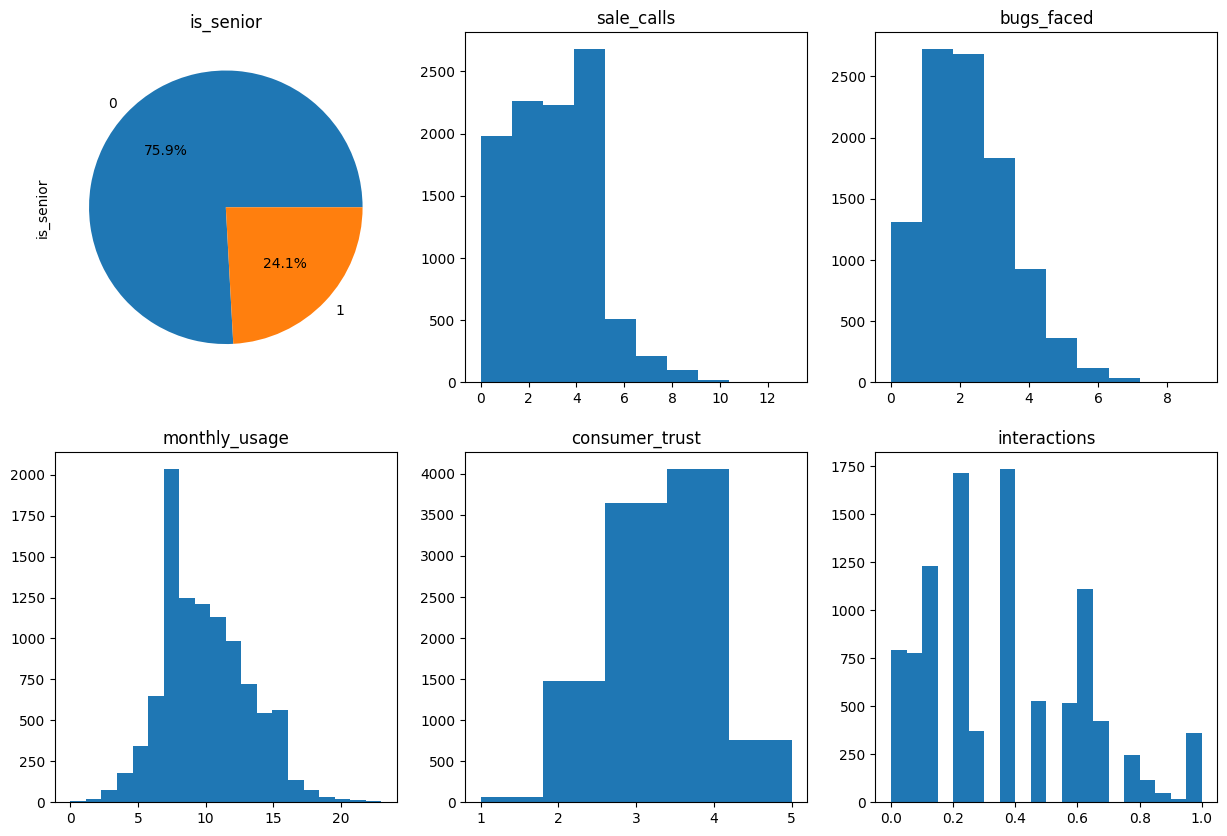

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))


df['is_senior'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax.flatten()[0])
ax.flatten()[0].set_title('is_senior')

ax.flatten()[1].hist(df['sale_calls'], bins=10)
ax.flatten()[1].set_title('sale_calls')
# ax.flatten()[1].set_xlabel('# sales calls')

ax.flatten()[2].hist(df['bugs_faced'], bins=10)
ax.flatten()[2].set_title('bugs_faced')

ax.flatten()[3].hist(df['monthly_usage'], bins=20)
ax.flatten()[3].set_title('monthly_usage')


ax.flatten()[4].hist(df['consumer_trust'], bins=5)
ax.flatten()[4].set_title('consumer_trust')

ax.flatten()[5].hist(df['interactions'], bins=20)
ax.flatten()[5].set_title('interactions')

plt.show()

In [14]:
sm = StructureModel()
sm.add_edges_from(edges)
bn = BayesianNetwork(sm)

## Plotting

In [15]:
# Formatting
all_node_attributes = {
    "font": {
        "color": "#FFFFFFD9",
        "face": "Helvetica",
        "size": 20,
    },
    "shape": "diamond",
    "size": 15,
    "borderWidth": 2,
    "color": {
        "border": "#4a90e2d9",
        "background": "#001521"
    },
    "mass": 3
}
node_attributes = {
    "renewal": {
        "color": {
            "background": "#ff0000",
            "highlight": {
                "background": "#ffcccc",
                "border": "#cce0ff"
            }
        },
        "shape": "circle",
        "size": 50,
        "label": "renewal",
        "font": {
            "color": "#000000",
        },
        "fixed": {
            "y": True
        }
    },
    
    "consumer_trust": {
        "font": {
            "color": "#FFFFFFD9",
            "face": "Helvetica",
            "size": 20,
        },
        "shape": "box",
        "size": 15,
        "borderWidth": 2,
        "color": {
            "border": "#ff0000",
            "background": "#001521"
        },
        "mass": 3},

        "bugs_faced": {
            "font": {
                "color": "#FFFFFFD9",
                "face": "Helvetica",
                "size": 20,
            },
            "shape": "box",
            "size": 15,
            "borderWidth": 2,
            "color": {
                "border": "#4a90e2d9",
                "background": "#001521"
            },
            "mass": 3},

        "discount": {
            "font": {
                "color": "#FFFFFFD9",
                "face": "Helvetica",
                "size": 20,
            },
            "shape": "box",
            "size": 15,
            "borderWidth": 2,
            "color": {
                "border": "#4a90e2d9",
                "background": "#001521"
            },
            "mass": 3},

        "sale_calls": {
            "font": {
                "color": "#FFFFFFD9",
                "face": "Helvetica",
                "size": 20,
            },
            "shape": "box",
            "size": 15,
            "borderWidth": 2,
            "color": {
                "border": "#4a90e2d9",
                "background": "#001521"
            },
            "mass": 3},
    }

    

# Plotting
viz = plot_structure(
    sm, all_node_attributes=all_node_attributes, node_attributes=node_attributes
)
viz.height = 1000
# viz.show('webpages/DAG.html')
viz.save_graph('webpages/DAG.html')

In [16]:
discretised_data = df.copy()
# split discretised_data["interactions"] to 5 bins
discretised_data["interactions"] = pd.qcut(discretised_data["interactions"], 5, labels=False)


train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)


bn = bn.fit_node_states(discretised_data)
# bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")
bn = bn.fit_cpds(train, method="MaximumLikelihoodEstimator")
# bn.cpds["renewal"]
predictions = bn.predict(discretised_data, "renewal")


# replace values of certain columns with its dictionary values
readable_data = discretised_data.copy()
readable_data['is_senior'] = readable_data['is_senior'].map(is_senior_dict)
readable_data['discount'] = readable_data['discount'].map(discount_dict)
readable_data['renewal'] = readable_data['renewal'].map(renewal_dict)


n = np.random.randint(0, len(readable_data))
print("n =", n)
print("For the following scenario:")
print(readable_data.loc[n, readable_data.columns != 'renewal'])
print(f"\nPrediction is {renewal_dict[predictions.loc[n, 'renewal_prediction']]} with prob: XXX")
print(f"Ground truth is {readable_data.loc[n, 'renewal']}")

n = 334
For the following scenario:
is_senior          No
sale_calls          4
bugs_faced          1
monthly_usage      11
consumer_trust      3
interactions        0
discount          20%
Name: 334, dtype: object

Prediction is Yes with prob: XXX
Ground truth is Yes


## Fitting SEM to Observational Data

In [17]:
sm = from_pandas(discretised_data)
# bn = BayesianNetwork(sm)

# classification_report(bn, test, "renewal")
# roc, auc = roc_auc(bn, test, "renewal")
# print(auc)

In [18]:
infer = InferenceEngine(bn)
marginals = infer.query()

print(marginals["renewal"]) # = P(renewal = False), P(renewal = True)
# confirming w/ data:
print(discretised_data["renewal"].value_counts(normalize=True))

{0: 0.17450873480386578, 1: 0.8254912651961221}
1    0.8734
0    0.1266
Name: renewal, dtype: float64


## Experimentation
we explore the marginal: $P(\text{renewal}|\text{is senior}, \text{sales call}, \text{bugs faced}, \text{consumer trust}, \text{interactions}, \text{discount})$  
the do-conditional: $P\left( \text{renewal}|\text{do}(...), ...\right)$  
and the counterfactual: $P\left( \text{renewal}, ..., \text{do}(...)|, ...\right)$

In [19]:
discretised_data[(discretised_data["is_senior"] == 0) 
                 & (discretised_data["sale_calls"] == 3)
                 & (discretised_data["bugs_faced"] == 2)
                & (discretised_data["monthly_usage"] == 10)
            ].head()
# discretised_data.columns

,is_senior,sale_calls,bugs_faced,monthly_usage,consumer_trust,interactions,discount,renewal
110,0,3,2,10,4,1,2,1
397,0,3,2,10,4,1,4,1
778,0,3,2,10,4,1,1,1
783,0,3,2,10,3,1,3,1
934,0,3,2,10,4,1,4,1


In [33]:
print("current:", 
      infer.query({"is_senior": 1, "sale_calls": 2, "bugs_faced": 2, "consumer_trust": 4, "interactions": 1, "discount": 4, "monthly_usage":10})["renewal"])
# copmare with value for the same query using the SEM
print(renewal_function(1, 2, 2, 10, 4))


infer.do_intervention('sale_calls', 1)
print("intervened:", infer.query()['renewal'])
infer.reset_do('sale_calls') # reset interventions

current: {0: 0.0, 1: 0.0}
1
intervened: {0: 0.14931484115949628, 1: 0.850685158840501}


In [30]:
# split df.interactions to 5 bins
# df["interactions"] = pd.qcut(df["interactions"], 5, labels=False)
# df[1, 2, 2, 10, 4]
df[(df["is_senior"] == 1) 
                 & (df["sale_calls"] == 2)
                 & (df["bugs_faced"] == 2)
                & (df["monthly_usage"] == 10)
                & (df["interactions"] == 3)
            ]

,is_senior,sale_calls,bugs_faced,monthly_usage,consumer_trust,interactions,discount,renewal
431,1,2,2,10,3,3,4,1
1564,1,2,2,10,5,3,3,1
2002,1,2,2,10,3,3,4,1
2173,1,2,2,10,3,3,1,1
2950,1,2,2,10,4,3,3,1
2959,1,2,2,10,4,3,3,0
3019,1,2,2,10,3,3,3,1
3608,1,2,2,10,2,3,3,1
5176,1,2,2,10,4,3,4,1
5378,1,2,2,10,3,3,3,1


## Questions
* how to manually define loss function? make fal-neg > fal-pos?
* how does this handle latent variables?

## Notes:
* behavioral constructs can be VAE-ed, data-fusion if possible use MV-VAE, otherwise can add 'setting' edges that each represent different unconnected datasets.

---

## Best Course of Action:  
We have a target binary outcome $A$, we are given user characteristics $\vec x$ and the possible interventions $\vec y$.  
We would chose what to do based on:
$$\forall \vec x \text{ and } \vec x' = \vec x - \vec y$$
$$\text{arg max}_{\vec y}\left\{[P(A|\vec x, \space \text{do}(\vec y) ) - P(A|\vec x)]\cdot [\text{cost}(\vec x, A = \text{True}) - \text{cost}(\vec x, A = \text{False})] \right\}$$
